In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from config import DB_USERNAME, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
import keras_tuner as kt

# import warnings
# warnings.filterwarnings("ignore")

In [27]:
# Create a connection string with the postgreSQL info
database_access = f"postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"


In [28]:
# Establish a connection to the PostgreSQL database 
engine = create_engine(database_access)


In [29]:
# Write a SQL query to select data from the existing view in PostgreSQL 
query = 'SELECT * FROM "Wines"'


In [30]:
# Use Pandas to read the data from the SQL query and convert into a DataFrame 
wines_df = pd.read_sql_query(query, engine)


In [31]:
# Display the Dataframe
wines_df.head()

,id,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol_wine,quality,quality_categorisation
0,4799,White,6.2,0.260,0.20,8.00,0.047,35.0,111.0,0.99445,3.11,0.42,10.4,6,1
1,1159,Red,10.2,0.410,0.43,2.20,0.110,11.0,37.0,0.99728,3.16,0.67,10.8,5,0
2,315,Red,7.1,0.350,0.29,2.50,0.096,20.0,53.0,0.99620,3.42,0.65,11.0,6,1
3,31,Red,6.9,0.685,0.00,2.50,0.105,22.0,37.0,0.99660,3.46,0.57,10.6,6,1
4,3010,White,6.7,0.250,0.31,1.35,0.061,30.5,218.0,0.99388,3.16,0.53,9.5,5,0


## Correlation test(attempt)


Each feature correlation with target variable 'quality':
quality                 1.000000
alcohol_wine            0.444319
citric_acid             0.085532
free_sulfur_dioxide     0.055463
sulphates               0.038485
ph                      0.019506
residual_sugar         -0.036980
total_sulfur_dioxide   -0.041385
fixed_acidity          -0.076743
chlorides              -0.200666
volatile_acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


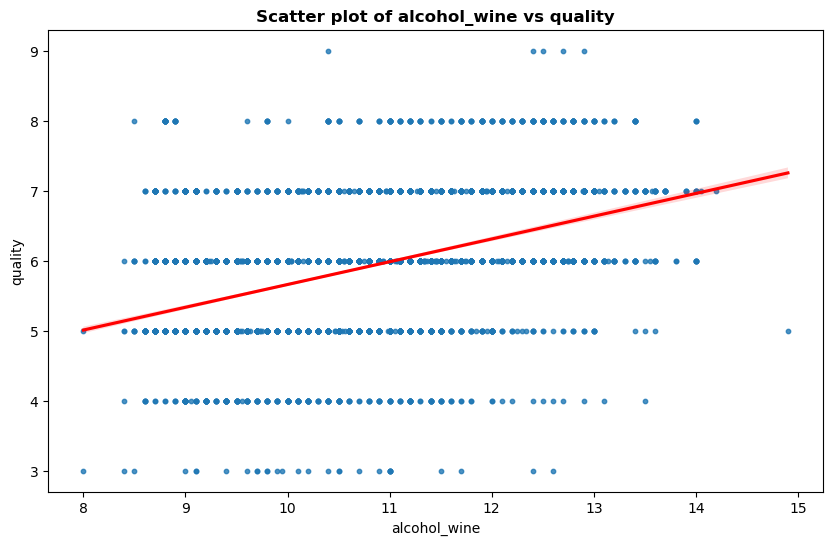

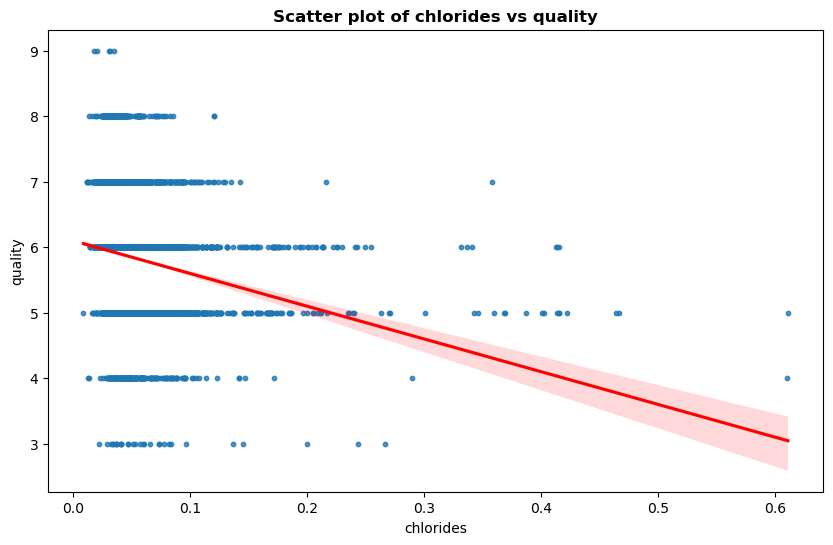

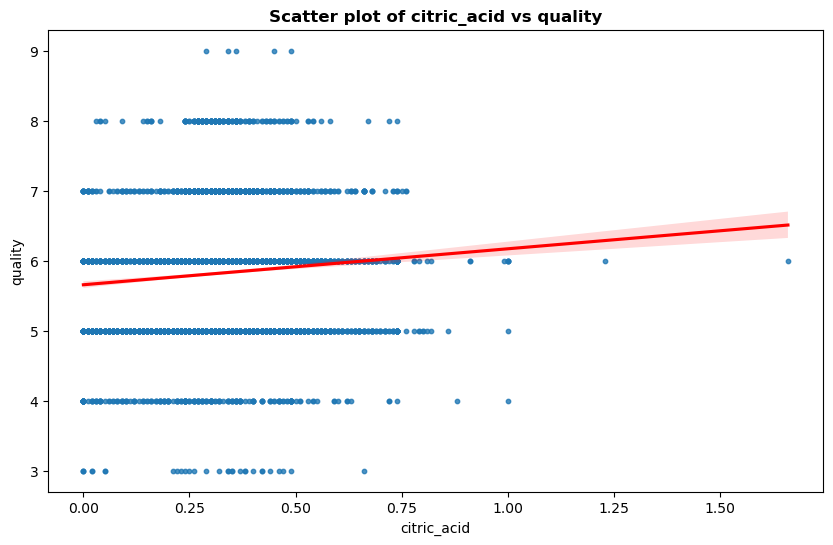

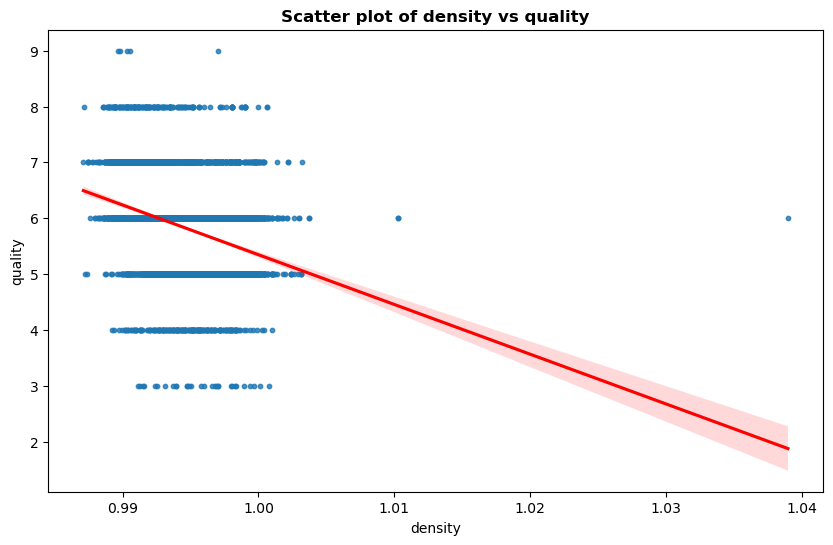

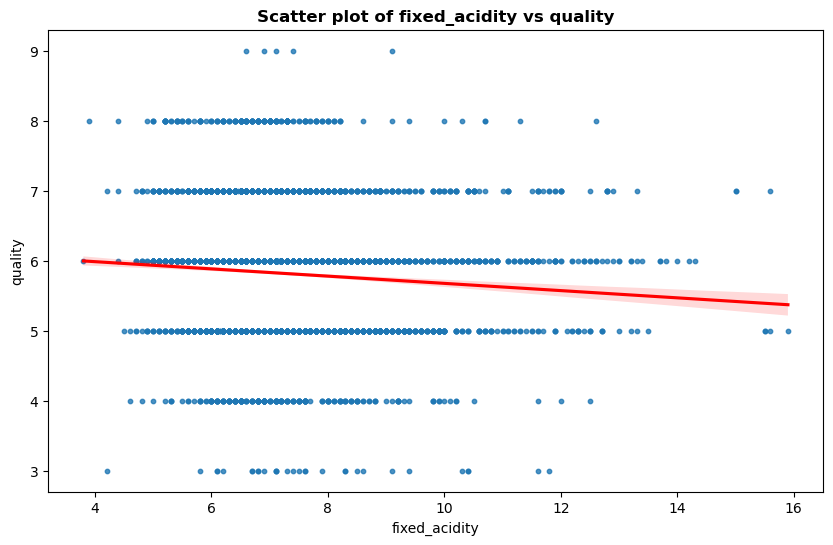

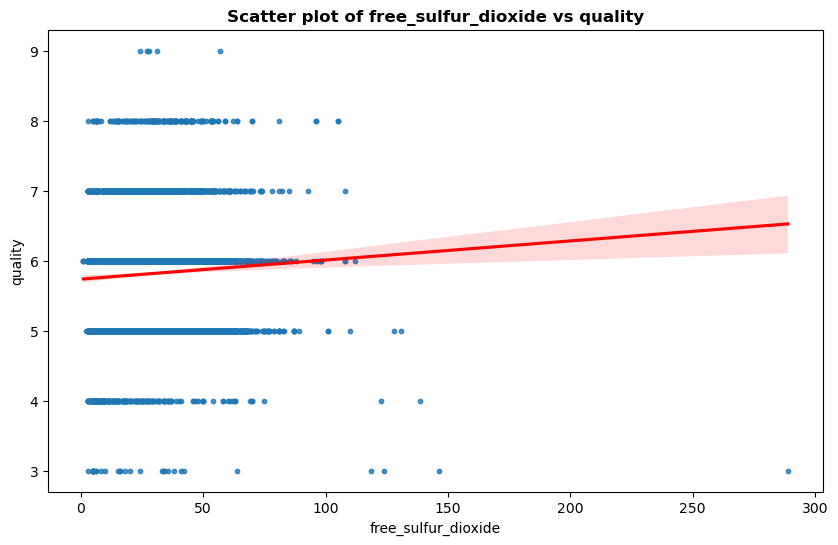

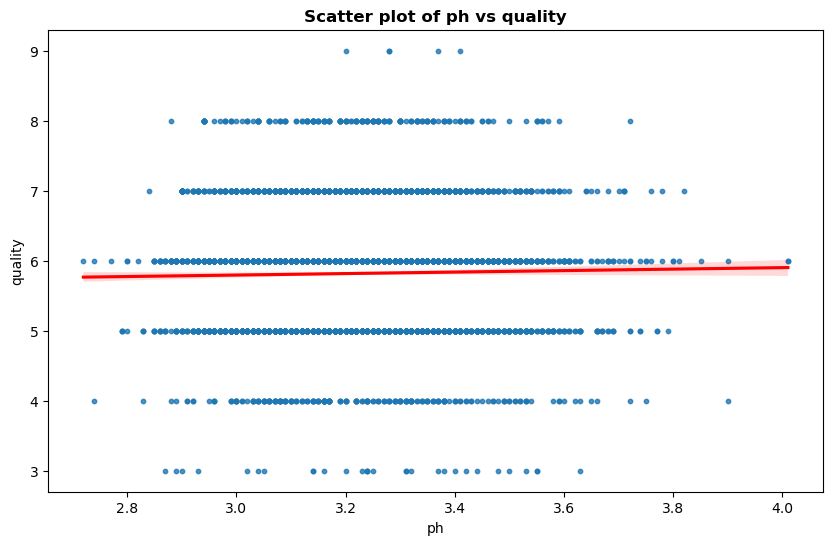

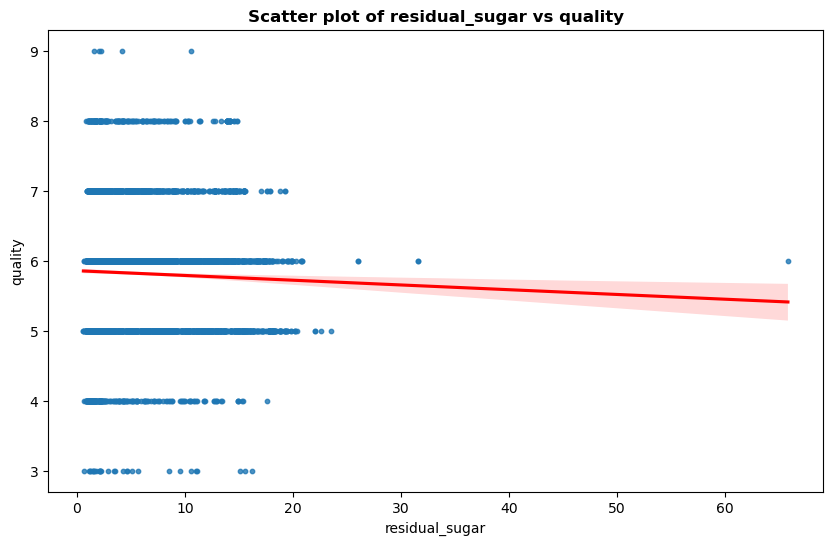

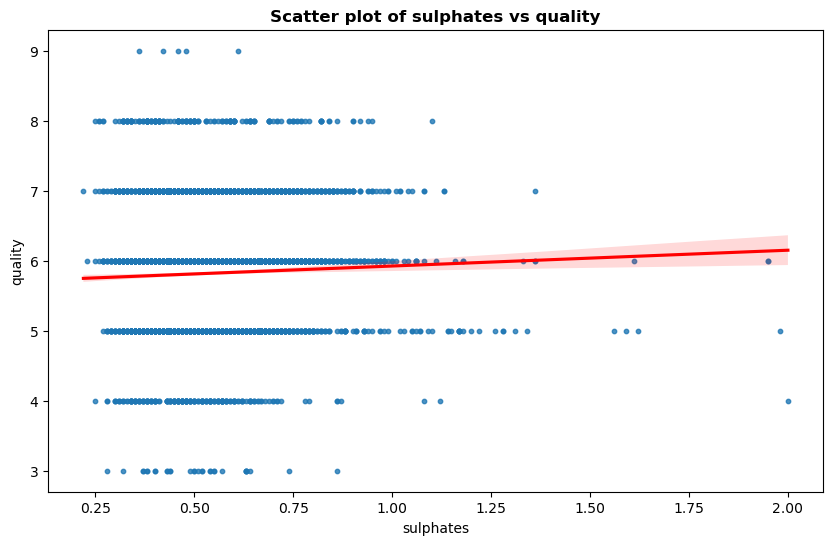

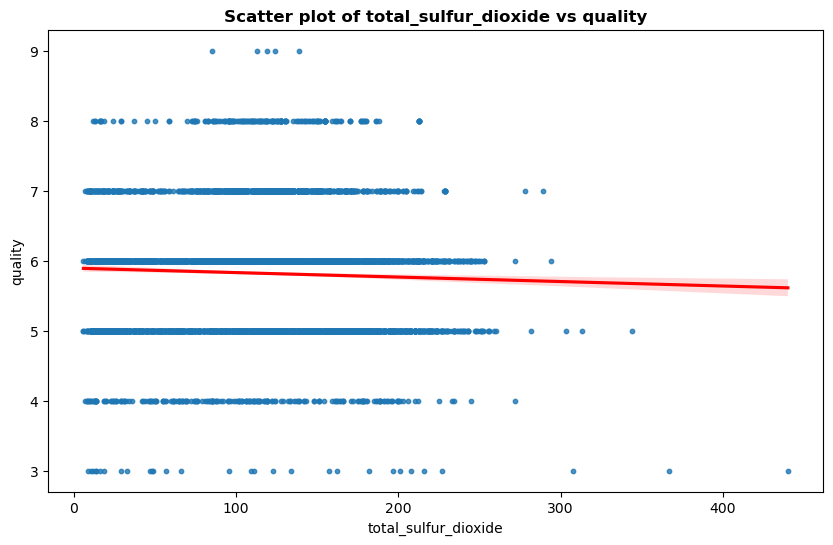

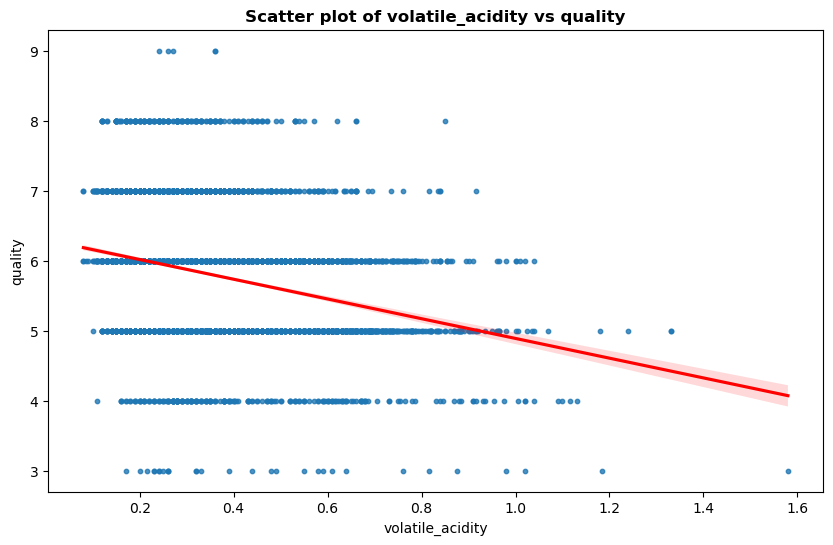

In [76]:

# Import seaborn
import seaborn as sns

# Remove non-numeric columns 
wines_df_numeric = wines_df.drop(columns=['id', 'type', 'quality_categorisation'])

# Calculate correlation between features and quality
correlations = wines_df_numeric.corr()['quality'].sort_values(ascending=False)
print("Each feature correlation with target variable 'quality':")
print(correlations)

# Plot scatter plot with red regression line
def plot_regression(df, features, target):
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.regplot(x=df[feature], y=df[target], scatter_kws={'s':10}, line_kws={'color': 'red'})
        
        # Set title in bold
        plt.title(f'Scatter plot of {feature} vs {target}', fontweight='bold')
        plt.xlabel(feature)
        plt.ylabel(target)
        
        plt.show()

# Plot scatter plots with red regression lines
features = wines_df_numeric.columns.difference(['quality'])
plot_regression(wines_df_numeric, features, 'quality')

## Optimisation test using Hyperparameters

In [81]:
# Import HyperModel, RandomSearch
from keras_tuner import HyperModel, RandomSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        # Adding multiple layers with tunable number of layers
        for i in range(hp.Int('num_layers', 2, 5)):
            # Adding a Dense layer with tunable number of units and activation function
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                activation=hp.Choice('activation', ['relu', 'tanh']),
                kernel_regularizer=keras.regularizers.l2(hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
            # Adding a Dropout layer with tunable dropout rate
            model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

        # Adding the output layer
        model.add(keras.layers.Dense(3, activation='softmax'))

        # Compiling the model with a tunable learning rate
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        return model



In [82]:
# Initialize the Keras Tuner with Random Search
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=2,
    directory='my_dir',  # The directory to save the search results
    project_name='wine_quality_tuning_v4'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)


Reloading Tuner from my_dir/wine_quality_tuning_v4/tuner0.json


In [83]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}, 
the optimal activation function is {best_hps.get('activation')},
the optimal number of units in the first densely-connected layer is {best_hps.get('units_0')}, 
the optimal number of units in the second densely-connected layer is {best_hps.get('units_1')}, 
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of layers is 5, 
the optimal activation function is relu,
the optimal number of units in the first densely-connected layer is 288, 
the optimal number of units in the second densely-connected layer is 256, 
the optimal learning rate for the optimizer is 0.00030476495908406733.



In [84]:
# Build the model with optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Set up early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the test dataset
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5700 - loss: 1.8170 - val_accuracy: 0.6327 - val_loss: 1.2745
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6218 - loss: 1.2366 - val_accuracy: 0.6327 - val_loss: 1.0540
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6293 - loss: 1.0377 - val_accuracy: 0.6288 - val_loss: 0.9626
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6201 - loss: 0.9453 - val_accuracy: 0.6269 - val_loss: 0.8927
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6288 - loss: 0.8967 - val_accuracy: 0.6240 - val_loss: 0.8588
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6244 - loss: 0.8590 - val_accuracy: 0.6279 - val_loss: 0.8177
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6306 - loss: 0.8220 - val_accuracy: 0.6327 - val_loss: 0.7932
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6524 - loss: 0.7819 - val_accu